<a href="https://colab.research.google.com/github/amirhosseinzinati/Cat-dog-classification-using-CNN/blob/main/Cat_And_Dog_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h2 style='padding:20px;text-align:center;border-radius:10px;background:black;color:white'>Import required libraries / dependencies</h2>

In [41]:
import opendatasets as od
import numpy as np
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization,RandomFlip,RandomRotation,CenterCrop,Rescaling
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import cv2 as cv

<h2 style='padding:20px;text-align:center;border-radius:10px;background:black;color:white'>Generate the datasets, both the training and the test sets</h2>

In [4]:
od.download("https://www.kaggle.com/datasets/tongpython/cat-and-dog")

Skipping, found downloaded files in "./cat-and-dog" (use force=True to force download)


In [5]:
#The paths to the dataset.
training_path = './cat-and-dog/training_set/training_set/'
test_path = './cat-and-dog/test_set/test_set/'


<h2 style='padding:20px;text-align:center;border-radius:10px;background:black;color:white'>
    Visualize some images from the training set
</h2>

In [ ]:
#Plot some images in the dataset.
def plot_image(path, int_type):
    _path = path
    label = None
    if int_type == 0:
        _path = _path + "/" + "cats"
        label = 0
    else:
        _path = _path + "/" + "dogs"
        label = 1
    
    plt.figure(figsize=(30, 30))
    plt.subplots_adjust(top=None, bottom=None, left=None, right=None, wspace=0.2, hspace=0.5)
    
    lst_img_name = os.listdir(_path)
    for i in range(1, 17, 1):
        th = np.random.randint(0, len(lst_img_name) - 1)
        plt.subplot(4, 4, i)
        img = _path + "/" + lst_img_name[th]
        img = cv.imread(img)
        plt.imshow(img)
        if label == 0:
            plt.title("Cat")
        else:
            plt.title("Dog")

In [ ]:
plot_image(training_path, 0)

In [ ]:
plot_image(training_path, 1)

<h2 style='padding:20px;text-align:center;border-radius:10px;background:black;color:white'>
    Build a model
</h2>

In [ ]:
# مشخص کردن مشخصات تصاویر
Image_Width=200
Image_Height=200
Image_Size=(Image_Width,Image_Height)
Image_Channels=3
Batch_Size=32

In [9]:
# Getting the train and test dataset into tensorflow batches
training_set = image_dataset_from_directory(training_path,
                                             batch_size=Batch_Size,
                                             image_size=Image_Size,
                                             shuffle=True,
                                             seed=123,
                                             validation_split=0.2,
                                             subset='training')

val_set = image_dataset_from_directory(directory=training_path,
                                           batch_size=Batch_Size,
                                           image_size=Image_Size,
                                           shuffle=True,
                                           validation_split=0.2,
                                           subset='validation',
                                           seed=123)

test_set = image_dataset_from_directory(test_path,
                                            batch_size=Batch_Size,
                                            image_size=Image_Size,
                                            shuffle=True,
                                            seed=123)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Found 8005 files belonging to 2 classes.
Using 1601 files for validation.
Found 2023 files belonging to 2 classes.


In [42]:
# Make CNN Model
model=Sequential()

model.add(Conv2D(128,(3,3),activation='relu',padding='same',input_shape=(Image_Width,Image_Height,Image_Channels)))
# preprocessing
model.add(CenterCrop(180, 180))
model.add(Rescaling(scale=1./255))
    
# applying image data augmentation
model.add(RandomFlip('horizontal'))
model.add(RandomRotation(0.1))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))


model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

model.add(Flatten())

model.add(Dense(1,activation='sigmoid'))


In [43]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 200, 200, 128)     3584      
                                                                 
 center_crop (CenterCrop)    (None, 180, 180, 128)     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 128)     0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 180, 180, 128)     0         
                                                                 
 random_rotation_2 (RandomRo  (None, 180, 180, 128)    0         
 tation)                                                         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 90, 90, 128)      0         
 g2D)                                                 

<h2 style='padding:20px;text-align:center;border-radius:10px;background:black;color:white'>
    Train the model
</h2>

In [44]:
epochs = 50
earlystop = EarlyStopping(patience = 10)
callbacks = [earlystop]

In [45]:
model.compile(loss='binary_crossentropy',
  optimizer='adam',metrics=['accuracy'],run_eagerly=True)

In [46]:
history = model.fit(training_set, validation_data=test_set, epochs=epochs, callbacks=callbacks)

Epoch 1/50
201/201 [==============================] - 92s 452ms/step - loss: 0.6844 - accuracy: 0.5459 - val_loss: 0.6603 - val_accuracy: 0.6233
Epoch 2/50
201/201 [==============================] - 88s 438ms/step - loss: 0.6295 - accuracy: 0.6440 - val_loss: 0.6360 - val_accuracy: 0.6342
Epoch 3/50
201/201 [==============================] - 88s 435ms/step - loss: 0.6029 - accuracy: 0.6746 - val_loss: 0.6429 - val_accuracy: 0.6278
Epoch 4/50
201/201 [==============================] - 88s 434ms/step - loss: 0.5767 - accuracy: 0.7003 - val_loss: 0.5942 - val_accuracy: 0.6817
Epoch 5/50
201/201 [==============================] - 88s 436ms/step - loss: 0.5613 - accuracy: 0.7133 - val_loss: 0.5402 - val_accuracy: 0.7133
Epoch 6/50
201/201 [==============================] - 88s 436ms/step - loss: 0.5305 - accuracy: 0.7317 - val_loss: 0.5498 - val_accuracy: 0.7187
Epoch 7/50
201/201 [==============================] - 88s 434ms/step - loss: 0.5143 - accuracy: 0.7459 - val_loss: 0.5477 - val_ac

In [50]:
# Saving Model
model.save("model1_cats_and_dogs.h5")

<h2 style='padding:20px;text-align:center;border-radius:10px;background:black;color:white'>
    Visualize the predicted images
</h2>

In [47]:
# Plot the chart for accuracy and loss on both training and validation
def plot_acc_loss(history):
    acc = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    
    loss = history.history['loss']
    loss_val = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'r', label='Traning Accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, loss_val, 'b', label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    
    plt.show()

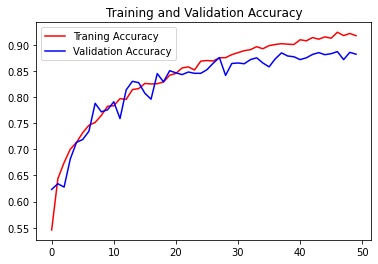

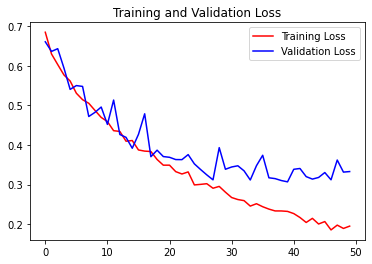

In [48]:
#Plot accuracy and loss.
plot_acc_loss(history)

1/1 [==============================] - 0s 52ms/step


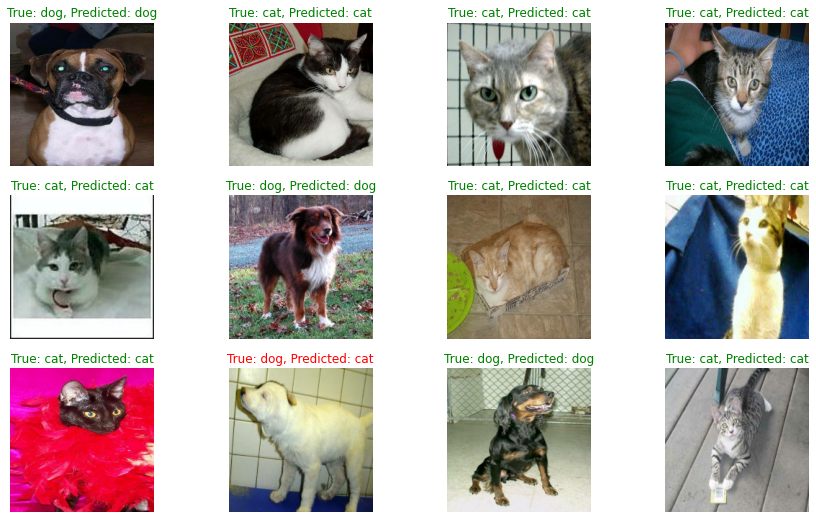

In [60]:
plt.figure(figsize=(15, 9))

def predict(imgs):
    pred = []
    for i in model.predict(images.numpy().astype('uint8')):
        if i[0] > .5:
            pred.append(1)
        else:
            pred.append(0)
    return pred
    
for images, labels in test_set.take(1):
    pred = predict(images)
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        if(int(labels[i])==pred[i]):
          plt.title(f'True: {"cat" if int(labels[i])==0 else "dog"}, Predicted: {"cat"  if pred[i]==0 else "dog"}',color="green")
        else:
          plt.title(f'True: {"cat" if int(labels[i])==0 else "dog"}, Predicted: {"cat"  if pred[i]==0 else "dog"}',color="red")
        plt.axis('off')

<div style='border-radius:10px;background:black;color:white;padding:25px'>
    Hey,<br>
    Thanks for your time reviewing my notebook.<br>
    please don't hesitate to leave a comment if you have anything to share about the kernel. <br>
<br><br>
    Keep building :)
    
</div>